# **Assignment 2: Topic Modelling**

### **Import Packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pandas --upgrade
!pip install matplotlib --upgrade

In [ ]:
pip install pyLDAvis

In [ ]:
pip install openpyxl==3.0.0

In [ ]:
pip install sweetviz

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

#Report
import sweetviz as sv

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


### **Prepare Stopwords**

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### **Import Radisson Hotel reviews data**

In [ ]:
# Import Dataset
df = pd.read_excel('/content/drive/MyDrive/Text_Analytics/Assignment 2/radisson_mumbai.xlsx')
df.head()

,revTitle,date,reviewer,rating,review
0,Excellent stay,July 2021,Tejas,5,Housekeeping staff is very friendly and hel...
1,Excellent stay,July 2021,Vinu george,5,"Excellent service, food is amazing, servi..."
2,Amazing service,July 2021,Preetha,5,Sapna yadav provided us with the best servi...
3,Excellent stay,July 2021,Dikshita,5,Excellent service like the staff attitude c...
4,Excellent stay,July 2021,Kajol Shah,5,Very good service.. food was also good.. br...


### **EDA**

In [ ]:
data = pd.DataFrame(df)
my_report = sv.analyze(data)
my_report.show_html() 

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
fig1 = px.histogram(df, x="rating",color="rating")
fig2 = px.histogram(df, x="date",y="rating",color="rating") 
fig1.show()
fig2.show()

### **Text Cleansing**

In [ ]:
# Replace email address with 'emailaddress'
df['review'] = df['review'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['review'] = df['review'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['review'] = df['review'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
df['review'] = df['review'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
df['review'] = df['review'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
df['review'] = df['review'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
df['review'] = df['review'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
df['review'] = df['review'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
df['review'] = df['review'].str.lower()

# remove non alphabets with whitespace
df['review'] = df['review'].str.replace(r'[^a-zA-Z]', ' ')

In [ ]:
df.review.head()

0     housekeeping staff is very friendly and helpf...
1     excellent service food is amazing service is ...
2     sapna yadav provided us with the best service...
3     excellent service like the staff attitude che...
4     very good service food was also good breakfas...
Name: review, dtype: object

### **Tokenize words and Clean-up text**

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['review']))
print(data_words[:1])


[['housekeeping', 'staff', 'is', 'very', 'friendly', 'and', 'helpful', 'specially', 'thanks', 'to', 'mr', 'montoo', 'housekeeping', 'manager', 'laxman', 'gurav', 'enjoying', 'stay', 'food', 'also', 'good', 'also', 'the', 'covid', 'number', 'guild', 'line', 'was', 'properly', 'followed', 'and', 'in', 'very', 'safely', 'manner']]


### **Create Bigram and Trigram Models**

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['housekeeping', 'staff', 'is', 'very', 'friendly', 'and', 'helpful', 'specially', 'thanks', 'to', 'mr', 'montoo', 'housekeeping', 'manager', 'laxman_gurav', 'enjoying', 'stay', 'food', 'also', 'good', 'also', 'the', 'covid', 'number', 'guild', 'line', 'was', 'properly', 'followed', 'and', 'in', 'very', 'safely', 'manner']


### **Remove Stopwords, Make Bigrams and Lemmatize**

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [ ]:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['housekeeping', 'staff', 'friendly', 'helpful', 'specially', 'thank', 'manager', 'laxman_gurav', 'enjoy', 'stay', 'food', 'also', 'good', 'also', 'covid', 'number', 'guild', 'line', 'properly', 'follow', 'safely', 'manner']]


In [ ]:
wordlist = ' '.join(map(str, data_lemmatized))

In [ ]:
wordlist  = wordlist.replace("'", "")
wordlist

'[housekeeping, staff, friendly, helpful, specially, thank, manager, laxman_gurav, enjoy, stay, food, also, good, also, covid, number, guild, line, properly, follow, safely, manner] [excellent, service, food, amazing, service, perfect, friendly, staff, reception, service, reception, sandeep, sumitha, always, smile, face, love, hotel, ambience] [provide, good, service, ever, day, staff, make, sure, clean, room, regularly, provide, amenity, member, super, kind, super, friendly, well] [excellent, service, staff, attitude, check, smooth, staff, sandeep, helpful, quick, service, sumita, nice, helpful, room, clean, food, service, quick] [good, food, also, good, breakfast, amazing, staff, service, fantastic, must, try, allow, early, check, also, flight, land, quite, early, room, well, set, comfortable, stay] [housekeeping, staff, friendly, helpful, specially, thank, manager, laxman_gurav, enjoy, stay, food, also, good, also, covid, number, guild, line, properly, follow, safely, manner] [excel

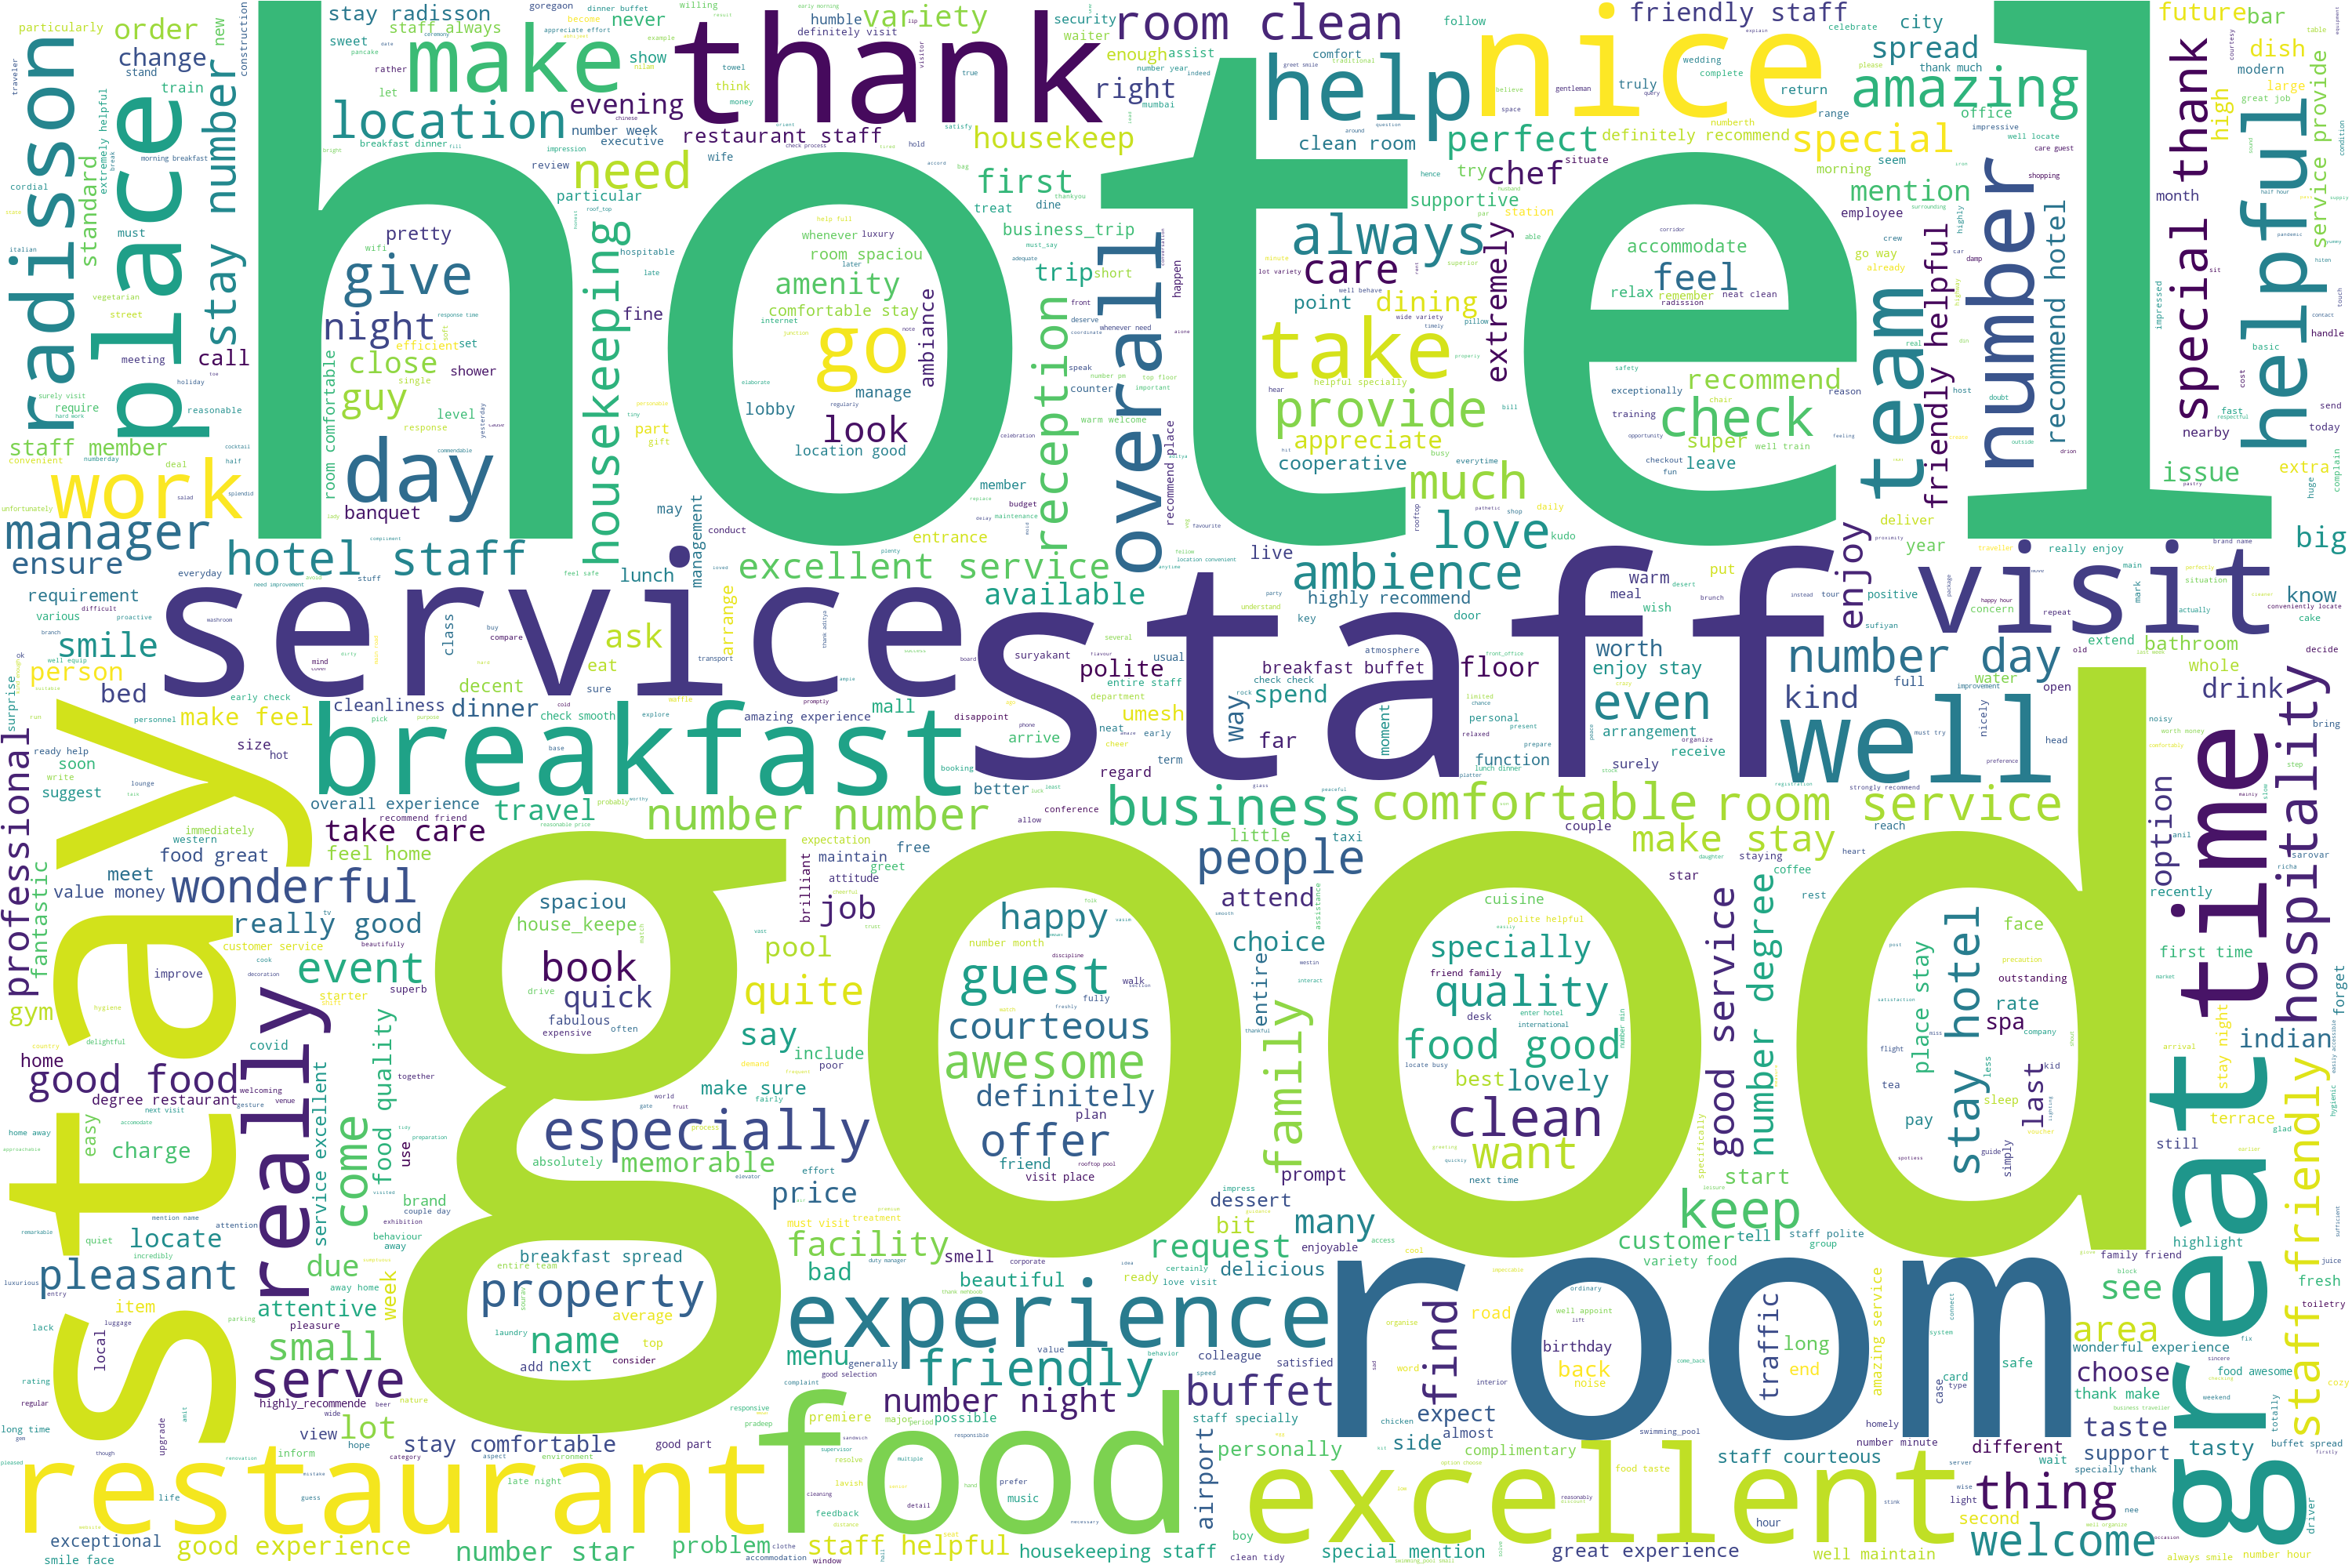

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=25, width = 3000, height = 2000,contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(wordlist)

# Visualize the word cloud
wordcloud.to_image()

### **Create the Dictionary and Corpus needed for Topic Modeling**

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


## **Building the Topic Model**

### **LSI Model**

In [ ]:
from gensim import corpora, models
lsi_model = models.LsiModel(corpus=corpus, num_topics=10, id2word=id2word)
lsi_model.show_topics(num_topics=5)

[(0,
  '0.382*"good" + 0.344*"stay" + 0.341*"hotel" + 0.320*"staff" + 0.294*"room" + 0.257*"number" + 0.225*"service" + 0.193*"food" + 0.114*"great" + 0.114*"thank"'),
 (1,
  '0.689*"good" + -0.436*"number" + -0.297*"hotel" + -0.222*"stay" + 0.197*"service" + -0.193*"room" + 0.162*"food" + -0.087*"day" + 0.072*"excellent" + -0.065*"would"'),
 (2,
  '0.463*"room" + 0.397*"good" + 0.289*"hotel" + -0.287*"stay" + -0.267*"staff" + -0.229*"thank" + -0.201*"great" + -0.195*"service" + -0.179*"food" + -0.145*"make"'),
 (3,
  '0.711*"number" + -0.412*"stay" + -0.242*"hotel" + 0.239*"food" + 0.207*"service" + -0.145*"staff" + -0.140*"room" + -0.093*"helpful" + 0.080*"good" + 0.075*"day"'),
 (4,
  '0.688*"hotel" + -0.483*"stay" + -0.366*"room" + 0.191*"staff" + 0.117*"great" + -0.114*"number" + -0.113*"good" + 0.098*"food" + -0.061*"night" + -0.059*"check"')]

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('Coherence Score: ', coherence_lsi)

Coherence Score:  0.3659415600748722


### **LDA Model**

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### **View the topics in LDA model**

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"evening" + 0.014*"eat" + 0.013*"include" + 0.012*"support" + '
  '0.010*"hot" + 0.010*"greet" + 0.009*"particularly" + 0.009*"review" + '
  '0.009*"improve" + 0.009*"attitude"'),
 (1,
  '0.031*"number" + 0.016*"hour" + 0.011*"night" + 0.011*"book" + '
  '0.009*"could" + 0.009*"day" + 0.008*"however" + 0.008*"get" + 0.008*"say" + '
  '0.007*"ask"'),
 (2,
  '0.045*"good" + 0.041*"hotel" + 0.039*"stay" + 0.036*"room" + 0.036*"staff" '
  '+ 0.026*"number" + 0.024*"service" + 0.016*"food" + 0.013*"great" + '
  '0.013*"also"'),
 (3,
  '0.029*"food" + 0.028*"visit" + 0.023*"make" + 0.022*"place" + 0.020*"team" '
  '+ 0.017*"family" + 0.016*"love" + 0.014*"experience" + 0.014*"courteous" + '
  '0.013*"amazing"'),
 (4,
  '0.033*"business" + 0.019*"spacious" + 0.014*"bit" + 0.013*"road" + '
  '0.012*"side" + 0.012*"airport" + 0.012*"traffic" + 0.011*"small" + '
  '0.010*"bed" + 0.010*"bathroom"')]


### **Compute Model Perplexity and Coherence Score**


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.664730773068378

Coherence Score:  0.41609080871774384


### **Hyperparameter tuning**

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    best_parms = pd.DataFrame(model_results)
    pbar.close()


100%|██████████| 540/540 [1:13:17<00:00,  8.14s/it]


In [ ]:

sorted_df = best_parms.sort_values(["Coherence"], 
                                   ascending=False)
print(sorted_df)

    Validation_Set  Topics       Alpha  Beta  Coherence
253     75% Corpus      10        0.61  0.91   0.682134
208     75% Corpus       8  asymmetric  0.91   0.657332
238     75% Corpus       9  asymmetric  0.91   0.639549
123     75% Corpus       6        0.01  0.91   0.631265
178     75% Corpus       7  asymmetric  0.91   0.631095
..             ...     ...         ...   ...        ...
427    100% Corpus       7        0.31  0.61   0.315374
463    100% Corpus       8        0.61  0.91   0.311882
68      75% Corpus       4        0.31  0.91   0.297579
362    100% Corpus       5        0.01  0.61   0.297402
363    100% Corpus       5        0.01  0.91   0.291270

[540 rows x 5 columns]


### **Final Model**

In [ ]:
num_topics = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.61,
                                           eta=0.91)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"pranali" + 0.000*"favorite" + 0.000*"gre" + 0.000*"jam" + '
  '0.000*"heavy" + 0.000*"wherever" + 0.000*"handling" + 0.000*"grandeur" + '
  '0.000*"mid" + 0.000*"attraction"'),
 (1,
  '0.001*"discuss" + 0.001*"delicacy" + 0.001*"swedish" + 0.001*"refresh" + '
  '0.001*"mist" + 0.001*"theripist" + 0.001*"codingly" + 0.001*"assinge" + '
  '0.001*"loved" + 0.001*"fruit"'),
 (2,
  '0.002*"conference" + 0.002*"washroom" + 0.002*"registration" + '
  '0.002*"amount" + 0.001*"mother" + 0.001*"reservation" + 0.001*"earth" + '
  '0.001*"claim" + 0.001*"shock" + 0.001*"yet"'),
 (3,
  '0.015*"event" + 0.006*"banquet" + 0.005*"function" + 0.002*"entire" + '
  '0.002*"hold" + 0.002*"host" + 0.002*"traditional" + 0.002*"ceremony" + '
  '0.002*"effort" + 0.002*"venue"'),
 (4,
  '0.001*"slightly" + 0.001*"decide" + 0.001*"design" + 0.001*"minimum" + '
  '0.001*"block" + 0.001*"accessibility" + 0.001*"site" + 0.001*"glass" + '
  '0.001*"impression" + 0.001*"latter"'),
 (5,
  '0.002*"fry" 

### **Visualize the topics-keywords**

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.256982  0.000187       1        1  73.617561
9     -0.028484 -0.045389       2        1   6.121947
3     -0.031245  0.018199       3        1   3.474375
7     -0.029906  0.008398       4        1   2.664474
2     -0.028731  0.004667       5        1   2.621447
4     -0.028375  0.003418       6        1   2.489905
6     -0.027673  0.003037       7        1   2.280977
5     -0.027603  0.002792       8        1   2.275920
1     -0.027640  0.002582       9        1   2.269622
0     -0.027323  0.002109      10        1   2.183772, topic_info=          Term        Freq       Total Category  logprob  loglift
6         good  637.000000  637.000000  Default  30.0000  30.0000
26       hotel  581.000000  581.000000  Default  29.0000  29.0000
19        stay  553.000000  553.000000  Default  28.0000  28.0000
253      event   20.000000   20.000000  Default  27.0000  27.0000
18       staff  511.000000  511.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
2740     bless    0.231915    4.952437  Topic10  -7.8873   0.7629
1919       con    0.232073    5.684025  Topic10  -7.8866   0.6258
1923       pro    0.232073    5.684025  Topic10  -7.8866   0.6258
1418  superior    0.232670   10.365410  Topic10  -7.8840   0.0275
2069      lose    0.232121    6.215622  Topic10  -7.8864   0.5366

[499 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1520      1  0.311372  accessibility
1520      6  0.311372  accessibility
1692      1  0.355714   accidentally
1821      1  0.250457       accolade
1821      3  0.250457       accolade
...     ...       ...            ...
1413      1  0.645300      yesterday
1413      5  0.129060      yesterday
1590      1  0.253268            yet
1590      5  0.253268            yet
3028      1  0.275998          young

[698 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 4, 8, 3, 5, 7, 6, 2, 1])

### **Building LDA Mallet Model**

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

In [ ]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = 'C:/Users/Lenovo/Desktop/mallet-2.0.8/bin/mallet' # update this path
#mallet_path = '/content/drive/MyDrive/Text_Analytics/Assignment 2/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('great', 0.1339605734767025),
   ('good', 0.10349462365591398),
   ('food', 0.1003584229390681),
   ('nice', 0.08557347670250896),
   ('location', 0.042114695340501794),
   ('business', 0.04077060931899642),
   ('friendly', 0.033602150537634407),
   ('enjoy', 0.025537634408602152),
   ('facility', 0.01881720430107527),
   ('long', 0.01478494623655914)]),
 (1,
  [('good', 0.2589590443686007),
   ('service', 0.15059726962457337),
   ('excellent', 0.0985494880546075),
   ('provide', 0.04479522184300341),
   ('courteous', 0.029436860068259386),
   ('ambience', 0.027303754266211604),
   ('dinner', 0.023464163822525596),
   ('spread', 0.022610921501706484),
   ('quality', 0.021331058020477817),
   ('evening', 0.014078498293515358)]),
 (2,
  [('stay', 0.12384937238493723),
   ('make', 0.09832635983263599),
   ('day', 0.04686192468619247),
   ('feel', 0.04309623430962343),
   ('work', 0.04184100418410042),
   ('comfortable', 0.037238493723849374),
   ('home', 0.025523012552301255),
  

### **Optimal number of topics for LDA**

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

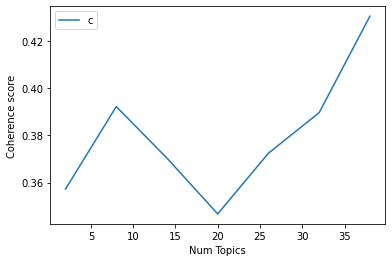

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3573
Num Topics = 8  has Coherence Value of 0.3922
Num Topics = 14  has Coherence Value of 0.3703
Num Topics = 20  has Coherence Value of 0.3467
Num Topics = 26  has Coherence Value of 0.3725
Num Topics = 32  has Coherence Value of 0.3897
Num Topics = 38  has Coherence Value of 0.4305


In [ ]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(20,
  '0.112*"clean" + 0.095*"locate" + 0.059*"close" + 0.049*"find" + '
  '0.049*"airport" + 0.039*"mall" + 0.034*"city" + 0.033*"minute" + '
  '0.026*"traffic" + 0.025*"free"'),
 (8,
  '0.242*"hotel" + 0.076*"reception" + 0.045*"time" + 0.041*"call" + '
  '0.040*"book" + 0.040*"room" + 0.037*"point" + 0.024*"meet" + 0.022*"card" + '
  '0.021*"accommodate"'),
 (10,
  '0.142*"care" + 0.083*"work" + 0.074*"guy" + 0.065*"job" + 0.056*"housekeep" '
  '+ 0.051*"person" + 0.047*"people" + 0.046*"big" + 0.039*"umesh" + '
  '0.033*"fantastic"'),
 (27,
  '0.131*"food" + 0.128*"love" + 0.108*"awesome" + 0.100*"visit" + '
  '0.051*"month" + 0.041*"restaurant" + 0.032*"birthday" + 0.028*"warm" + '
  '0.019*"celebrate" + 0.016*"traveller"'),
 (14,
  '0.213*"room" + 0.070*"small" + 0.050*"pool" + 0.041*"bed" + 0.038*"gym" + '
  '0.030*"water" + 0.030*"spacious" + 0.028*"bathroom" + 0.024*"complimentary" '
  '+ 0.022*"view"'),
 (3,
  '0.321*"experience" + 0.178*"amazing" + 0.059*"wonderful" + '
  

Those were the topics for the chosen LDA model.

### **Finding the dominant topic in each sentence**

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['review'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.0609,"number, night, degree, restaurant, laundry, pr...",housekeeping staff is very friendly and helpf...
1,1,35.0,0.0618,"service, excellent, quick, dinner, supportive,...",excellent service food is amazing service is ...
2,2,0.0,0.0704,"room, clean, maintain, super, spacious, neat, ...",sapna yadav provided us with the best service...
3,3,35.0,0.0867,"service, excellent, quick, dinner, supportive,...",excellent service like the staff attitude che...
4,4,29.0,0.0909,"check, room, night, staff, issue, morning, tra...",very good service food was also good breakfas...
5,5,5.0,0.0625,"stay, enjoy, pleasant, specially, facility, br...",housekeeping staff is very friendly and helpf...
6,6,35.0,0.0635,"service, excellent, quick, dinner, supportive,...",excellent service food is amazing service is ...
7,7,0.0,0.0654,"room, clean, maintain, super, spacious, neat, ...",sapna yadav provided us with the best service...
8,8,35.0,0.0931,"service, excellent, quick, dinner, supportive,...",excellent service like the staff attitude che...
9,9,29.0,0.0860,"check, room, night, staff, issue, morning, tra...",very good service food was also good breakfas...


### **Finding the most representative document for each topic**


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1176,"room, clean, maintain, super, spacious, neat, ...",the hotel room is clean and tidy bedding are ...
1,1.0,0.1022,"staff, courteous, customer, wonderful, cleanli...",i have stayed in hotel radisson mumbai gorega...
2,2.0,0.1907,"hotel, location, perfect, choice, bit, find, p...",booked directly on the hotel website so need ...
3,3.0,0.0966,"experience, amazing, wonderful, memorable, peo...",had a great experience staying with radissonh...
4,4.0,0.1967,"property, money, worth, hour, standard, order,...",had an awesome stay in this beautiful hotel g...


### **Topic distribution across documents**

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,19.0,"number, night, degree, restaurant, laundry, pr...",29.0,0.029
1.0,35.0,"service, excellent, quick, dinner, supportive,...",24.0,0.024
2.0,0.0,"room, clean, maintain, super, spacious, neat, ...",22.0,0.022
3.0,35.0,"service, excellent, quick, dinner, supportive,...",34.0,0.034
4.0,29.0,"check, room, night, staff, issue, morning, tra...",25.0,0.025
5.0,5.0,"stay, enjoy, pleasant, specially, facility, br...",24.0,0.024
6.0,35.0,"service, excellent, quick, dinner, supportive,...",17.0,0.017
7.0,0.0,"room, clean, maintain, super, spacious, neat, ...",33.0,0.033
8.0,35.0,"service, excellent, quick, dinner, supportive,...",18.0,0.018
9.0,29.0,"check, room, night, staff, issue, morning, tra...",37.0,0.037
